# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ The first *two* exercises below can probably be done *without* any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

In [1]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

from typing import Optional, Union
from functools import reduce
from sklearn.metrics import accuracy_score, classification_report

import os
from datetime import datetime
import re

from datasets import load_dataset, load_from_disk
from dataclasses import dataclass
from transformers import DistilBertModel, AutoTokenizer, DataCollatorWithPadding, AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

import matplotlib.pyplot as plt
import wandb

# torch.cuda.is_available()

---
# Exercise 3.1: Training a Text Classifier (easy)

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.

In [2]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (batch)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs = batch["input_ids"].to(device)
        ms = batch["attention_mask"].to(device)
        ys = batch["labels"].to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs, ms)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (batch)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs = batch["input_ids"].to(device)
            ms = batch["attention_mask"].to(device)
            ys = batch["labels"].to(device)

            # Forward pass
            logits = model(xs, ms)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 2"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [3]:
# BERT CLASSIFIER
class BERTClassifier(nn.Module):
    def __init__(self, model, n_classes):
        super().__init__()
        self.model = model
        self.classifier = nn.Sequential(
            nn.Linear(model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, n_classes)
        )

    def forward(self, x, mask):
        x = self.model(x, attention_mask=mask).last_hidden_state[:, 0]
        return self.classifier(x)

In [4]:
# TWEET DATASET
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length, normalize=False):
        self.texts = data["text"]
        self.labels = data["label"]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        self.data = data.map(self.preprocess_function, batched=False, remove_columns=["text", "label"])
        
    def normalize_text(self, text):
        # lowercase
        text = text.lower()
        # remove user tags
        text = re.sub(r'@\w', '', text)
        # Remove double spaces
        text = re.sub(r'\s+', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove hashtags
        text = re.sub(r'#', '', text)
        return text
    
    def preprocess_function(self, data):
        if self.normalize:
            data["text"] = self.normalize_text(data["text"])
        encoding = self.tokenizer(
            data["text"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(data["label"])
        }

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.data[idx]

### Tweet Eval Irony

In [12]:
# Save the tweet eval irony dataset
datasets = load_dataset("tweet_eval", "irony")
datasets.save_to_disk("../data/tweet_irony")

Saving the dataset (0/1 shards):   0%|          | 0/2862 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/784 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/955 [00:00<?, ? examples/s]

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]


Epoch 0: Train Loss: 0.6468, Train Acc: 0.6118, Val Loss: 0.6231, Val Acc: 0.6467


Evaluating: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]


Epoch 1: Train Loss: 0.4901, Train Acc: 0.7638, Val Loss: 0.6031, Val Acc: 0.6875


Evaluating: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]


Epoch 2: Train Loss: 0.2720, Train Acc: 0.8941, Val Loss: 0.6519, Val Acc: 0.6990


Evaluating: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]


Epoch 3: Train Loss: 0.1113, Train Acc: 0.9644, Val Loss: 0.9286, Val Acc: 0.7117


Evaluating: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]


Epoch 4: Train Loss: 0.0484, Train Acc: 0.9871, Val Loss: 1.2575, Val Acc: 0.6862


train/accuracy,▁▄▆██
train/epoch,▁▃▅▆█
train/loss,█▆▄▂▁
val/accuracy,▁▅▇█▅
val/epoch,▁▃▅▆█
val/loss,▁▁▂▄█
train/accuracy,0.98707
train/epoch,4
train/loss,0.04839
val/accuracy,0.68622
val/epoch,4


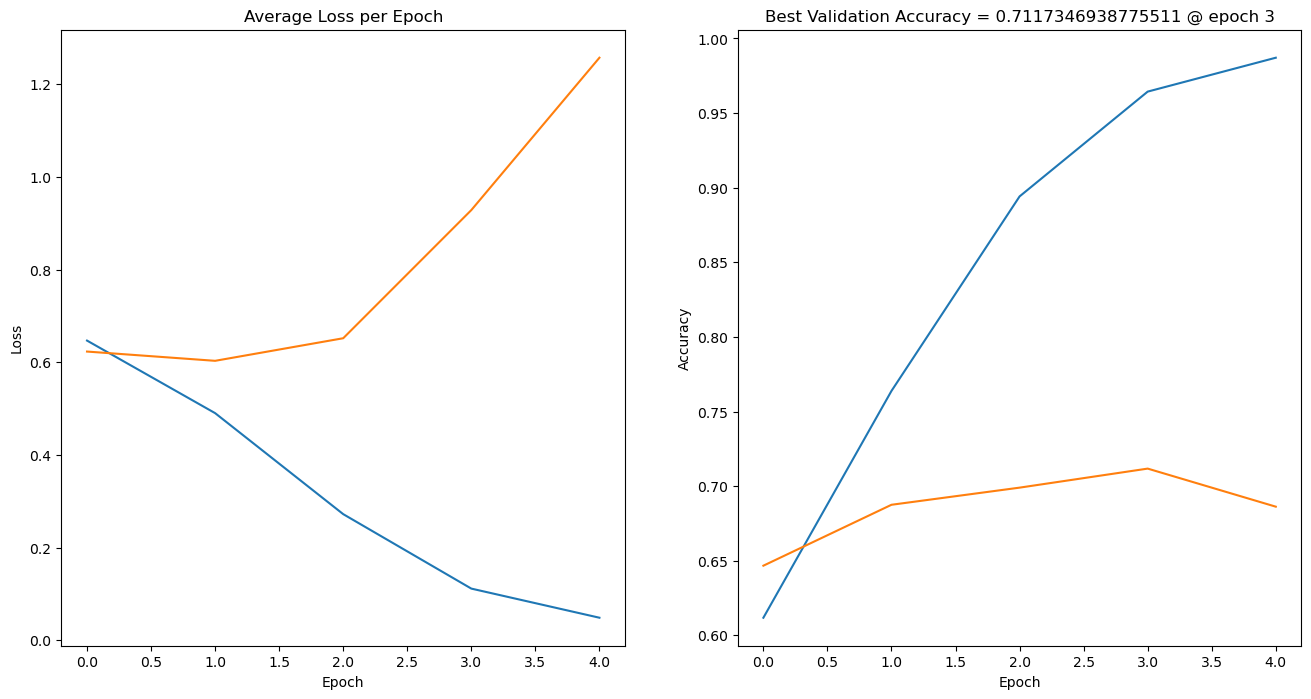

Model saved to model_states/DistilBERTClassifier-2024-07-10_13-17-33_tweet_irony_epochs-5_bs-8_lr-2e-05.pth


In [6]:
# TWEET EVAL DATASET IRONY
"""
Evaluate the irony of a tweet. The task is to classify whether a tweet is ironic or not.

The best results for the irony dataset with a pre-trained RoBERTa base is about 73% accuracy.
"""
# Dataset
dataset = load_from_disk("../data/tweet_irony")
classes_names = ["non_irony", "irony"]
n_classes = len(classes_names)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

max_length = 512
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)

ds_train = TweetDataset(dataset['train'], tokenizer, max_length=max_length)
ds_val = TweetDataset(dataset['test'], tokenizer, max_length=max_length)

data_collator = DataCollatorWithPadding(tokenizer)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

# Instantiate the model
model = BERTClassifier(DistilBertModel.from_pretrained('distilbert-base-uncased'), n_classes).to(device)

# Train the model
epochs = 5
lr = 2e-5
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=lr)

# Train the model
train_evaluate_model(
    model=model, 
    model_name="DistilBERTClassifier", 
    dataset_name="tweet_irony", 
    class_names=classes_names,
    dl_train=dl_train,
    dl_test=dl_val,
    batch_size=batch_size, 
    lr=lr,
    epochs=epochs, 
    opt=opt,
    device=device
)

### Tweet Eval Emoji

In [12]:
# Save the tweet eval emoji dataset
datasets = load_dataset("tweet_eval", "emoji")
datasets.save_to_disk("../data/tweet_emoji")

Saving the dataset (0/1 shards):   0%|          | 0/45000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 188/188 [04:16<00:00,  1.37s/it]


Epoch 0: Train Loss: 2.7683, Train Acc: 0.1993, Val Loss: 2.7189, Val Acc: 0.2167


Evaluating: 100%|██████████| 188/188 [04:07<00:00,  1.31s/it]


Epoch 1: Train Loss: 2.6102, Train Acc: 0.2340, Val Loss: 2.6092, Val Acc: 0.2447


Evaluating: 100%|██████████| 188/188 [03:53<00:00,  1.24s/it]


Epoch 2: Train Loss: 2.2780, Train Acc: 0.3480, Val Loss: 2.5458, Val Acc: 0.2580


Evaluating: 100%|██████████| 188/188 [03:52<00:00,  1.24s/it]


Epoch 3: Train Loss: 1.8934, Train Acc: 0.4773, Val Loss: 2.5872, Val Acc: 0.2680


Evaluating: 100%|██████████| 188/188 [03:52<00:00,  1.24s/it]


Epoch 4: Train Loss: 1.4547, Train Acc: 0.6320, Val Loss: 2.6342, Val Acc: 0.2507


train/accuracy,▁▂▃▅█
train/epoch,▁▃▅▆█
train/loss,█▇▅▃▁
val/accuracy,▁▅▇█▆
val/epoch,▁▃▅▆█
val/loss,█▄▁▃▅
train/accuracy,0.632
train/epoch,4
train/loss,1.45466
val/accuracy,0.25067
val/epoch,4


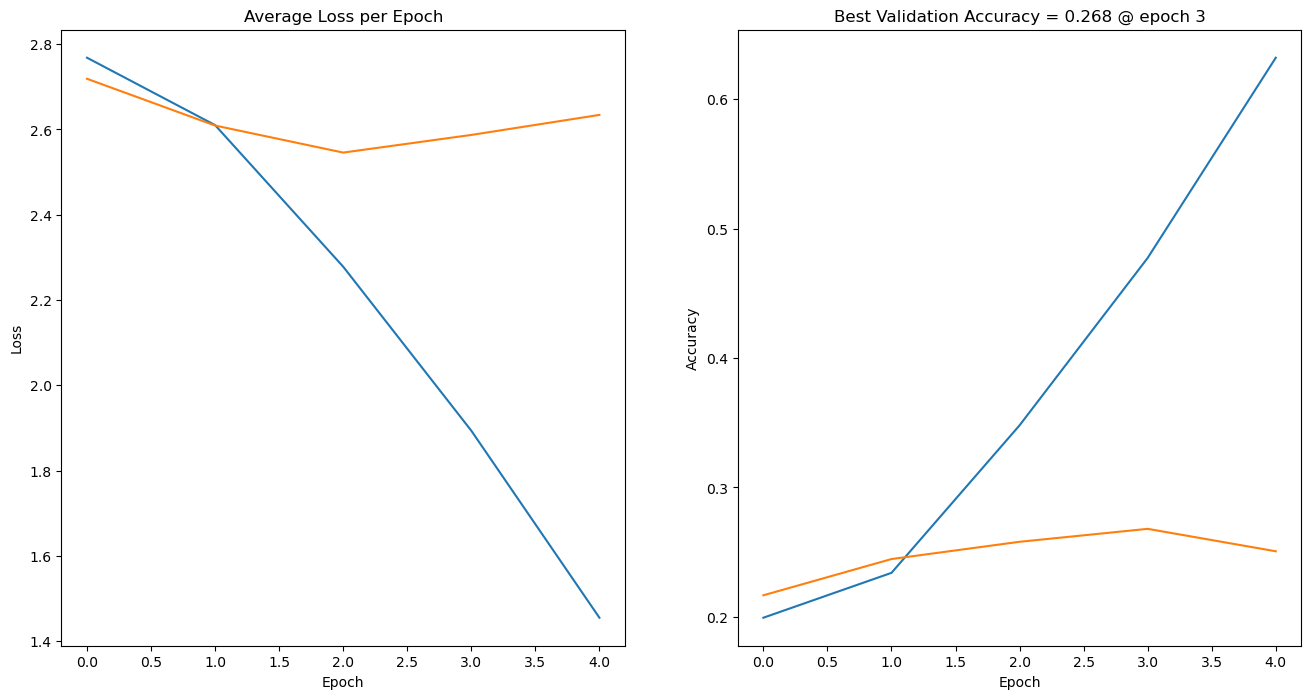

Model saved to model_states/DistilBERTClassifier-2024-07-10_14-32-03_emoji_epochs-5_bs-8_lr-2e-05.pth


In [12]:
# TWEET EVAL DATASET EMOJI
""" 
Evaluate the emoji of a tweet. The task is to classify which emoji is nearest to the sentiment of the tweet.

The best results for the emoji dataset with a pre-trained RoBERTa-Base is about 31% accuracy.
"""
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# Dataset
dataset = load_from_disk("../data/Tweet_emoji")
classes_names = ["❤️","😍","😂","💕","🔥","😊","😎","✨", "💙","😘","📷","🇺🇸","☀","💜","😉","💯","😁","🎄","📸","😜"]
n_classes = len(classes_names)

max_length = 512
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)

ds_train = TweetDataset(dataset['train'], tokenizer, max_length=max_length)
ds_val = TweetDataset(dataset['test'], tokenizer, max_length=max_length)

subset = 1500
ds_train = torch.utils.data.Subset(ds_train, range(subset))
ds_val = torch.utils.data.Subset(ds_val, range(subset))

data_collator = DataCollatorWithPadding(tokenizer)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

# Instantiate the model
model = BERTClassifier(DistilBertModel.from_pretrained('distilbert-base-uncased'), n_classes).to(device)

# Train the model
epochs = 5
lr = 2e-5
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=lr)

# Train the model
train_evaluate_model(
    model=model, 
    model_name="DistilBERTClassifier", 
    dataset_name="emoji", 
    class_names=classes_names,
    dl_train=dl_train,
    dl_test=dl_val,
    batch_size=batch_size, 
    lr=lr,
    epochs=epochs, 
    opt=opt,
    device=device
)

---
# Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

### ARC DATASET

In [5]:
# SAVE THE ARC DATASET ON DISK
ds = load_dataset("ai2_arc", "ARC-Easy")
ds.save_to_disk("../data/arc_easy")

Saving the dataset (0/1 shards):   0%|          | 0/2251 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2376 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/570 [00:00<?, ? examples/s]

In [4]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (batch)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs = batch["input_ids"].to(device)
        ms = batch["attention_mask"].to(device)
        ys = batch["labels"].to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs, ms)['logits']

        # Get the predicted classes
        pred = torch.argmax(logits, 1)

        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (batch)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs = batch["input_ids"].to(device)
            ms = batch["attention_mask"].to(device)
            ys = batch["labels"].to(device)

            # Forward pass
            logits = model(xs, ms)['logits']

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 2"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "AdamW",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [2]:
# Dataset class and collator for Multiple Choice
class ARC_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        data = data.remove_columns(["id"])
        self.data = data.map(self._preprocess_function, batched=False, remove_columns=["question", "choices", "answerKey"])
        # Remove row where the answers are not 4 and print the number of rows removed
        self.data = self.data.filter(lambda x: len(x["input_ids"]) == 4)
        print(f"Removed {len(data) - len(self.data)} rows")

    def _preprocess_function(self, data):
        question = data["question"]
        candidates = data["choices"]["text"]
        labels_answers = data["choices"]["label"]

        # Convert the label to a number where is the index of the correct answer
        data["label"] = labels_answers.index(data["answerKey"])

        n_answers = len(candidates)
        first_sentence = [question for i in range(n_answers)]
        second_sentence = [data["choices"]["text"][i] for i in range(n_answers)]
        tokenized_examples = tokenizer(first_sentence, second_sentence, truncation=True)
        return {"input_ids": tokenized_examples["input_ids"], "attention_mask": tokenized_examples["attention_mask"], "label": data["label"]}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


Removed 10 rows
Removed 11 rows


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 296/296 [02:01<00:00,  2.43it/s]


Epoch 0: Train Loss: 1.3852, Train Acc: 0.2606, Val Loss: 1.3616, Val Acc: 0.4715


Evaluating: 100%|██████████| 296/296 [02:01<00:00,  2.43it/s]


Epoch 1: Train Loss: 1.2426, Train Acc: 0.4485, Val Loss: 1.1634, Val Acc: 0.5070


Evaluating: 100%|██████████| 296/296 [01:44<00:00,  2.83it/s]


Epoch 2: Train Loss: 0.7937, Train Acc: 0.6867, Val Loss: 1.1943, Val Acc: 0.5264


train/accuracy,▁▄█
train/epoch,▁▅█
train/loss,█▆▁
val/accuracy,▁▆█
val/epoch,▁▅█
val/loss,█▁▂
train/accuracy,0.68675
train/epoch,2
train/loss,0.79372
val/accuracy,0.52643
val/epoch,2


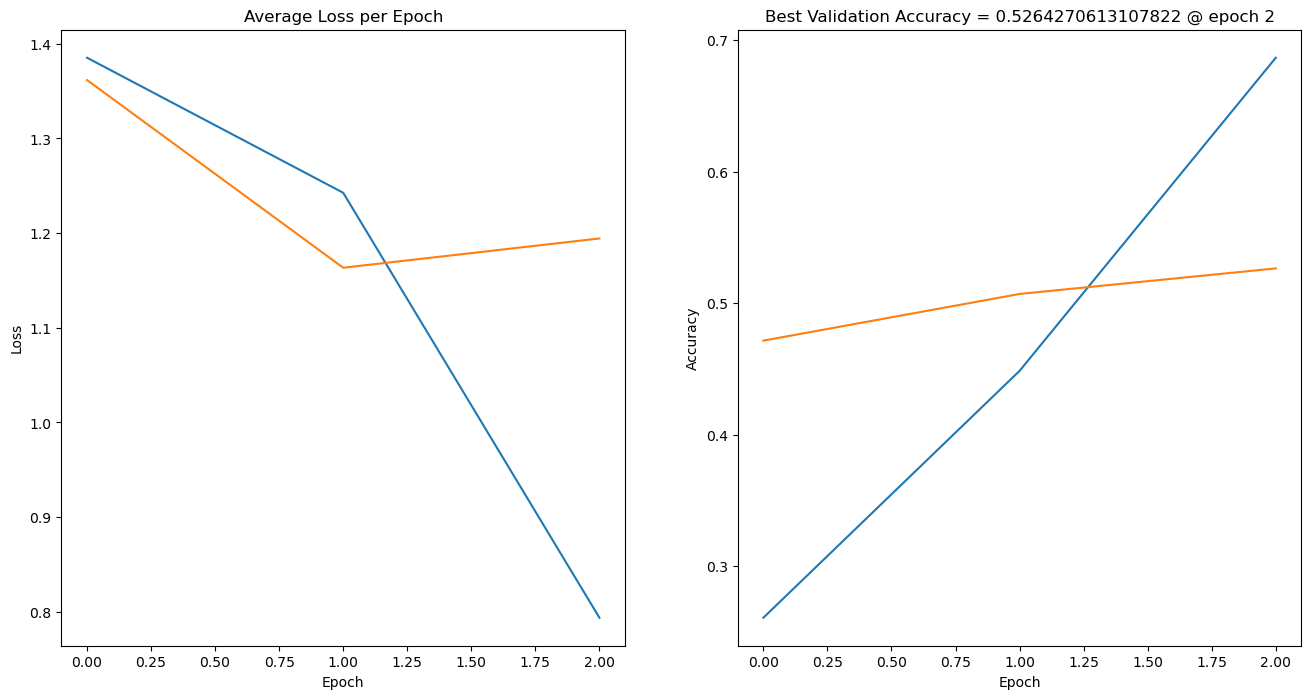

Model saved to model_states/DistilBERT-MultipleChoice-2024-07-10_12-03-18_ARC-Easy_epochs-3_bs-8_lr-2e-05.pth


In [5]:
# Load the dataset
dataset = load_from_disk("../data/arc_easy")

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
max_length = 512

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

train_ds = ARC_Dataset(dataset['train'], tokenizer, max_length=max_length)
test_ds = ARC_Dataset(dataset['test'], tokenizer, max_length=max_length)

# DataLoader
batch_size = 8

data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
dl_test = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

model = AutoModelForMultipleChoice.from_pretrained("bert-base-uncased").to(device)

# Train the model
epochs = 3
lr = 2e-5

opt = torch.optim.AdamW(model.parameters(), lr=lr)

# Train the model
train_evaluate_model(
    model=model, 
    model_name="DistilBERT-MultipleChoice", 
    dataset_name="ARC-Easy", 
    class_names=["A", "B", "C", "D"],
    dl_train=dl_train,
    dl_test=dl_test,
    batch_size=batch_size, 
    lr=lr,
    epochs=epochs, 
    opt=opt,
    device=device
)

### SWAG DATASET

In [6]:
# Prepare the dataset for the multiple choice task and the data collator
ending_names=["ending0","ending1","ending2","ending3"]

def preprocess_function(examples):
    first_sentences=[[context]*4 for context in examples["sent1"]]
    question_headers=examples["sent2"]
    second_sentences=[
        [f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)
    ]
    
    first_sentences=sum(first_sentences, [])
    second_sentences=sum(second_sentences, [])
    
    tokenized_examples=tokenizer(first_sentences, second_sentences, truncation=True)
    return {k:[v[i:i+4] for i in range(0, len(v),4)] for k,v in tokenized_examples.items()}

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int]=None
    pad_to_multiple_of: Optional[int]=None
    
    def __call__(self, features):
        label_name ="label" if "label" in features[0].keys() else "labels"
        labels=[feature.pop(label_name) for feature in features]
        batch_size=len(features)
        num_choices=len(features[0]["input_ids"])
        flattened_features=[
            [{k:v[i] for k,v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features=sum(flattened_features, [])
        
        batch=self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        batch={k:v.view(batch_size, num_choices, -1) for k,v in batch.items()}
        batch["labels"]=torch.tensor(labels, dtype=torch.int64)
        return batch

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
max_length = 512

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

# # Load a small subset of the dataset for computational reasons
ds = load_dataset("swag", "regular", split="train[:1000]") 
ds = ds.train_test_split(test_size=0.2)
ds = ds.map(preprocess_function, batched=True)

# DataLoader
batch_size = 8

data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

model = AutoModelForMultipleChoice.from_pretrained("bert-base-uncased").to(device)

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

args = TrainingArguments(
    "bert-finetuned-swag",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model,
    args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.9996693134307861, 'eval_accuracy': 0.6200000047683716, 'eval_runtime': 39.8151, 'eval_samples_per_second': 5.023, 'eval_steps_per_second': 0.628, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.9269726276397705, 'eval_accuracy': 0.6600000262260437, 'eval_runtime': 42.0799, 'eval_samples_per_second': 4.753, 'eval_steps_per_second': 0.594, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0263009071350098, 'eval_accuracy': 0.7049999833106995, 'eval_runtime': 42.4264, 'eval_samples_per_second': 4.714, 'eval_steps_per_second': 0.589, 'epoch': 3.0}
{'train_runtime': 1767.5741, 'train_samples_per_second': 1.358, 'train_steps_per_second': 0.17, 'train_loss': 0.6179675801595053, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.6179675801595053, metrics={'train_runtime': 1767.5741, 'train_samples_per_second': 1.358, 'train_steps_per_second': 0.17, 'total_flos': 242536882058688.0, 'train_loss': 0.6179675801595053, 'epoch': 3.0})

---
# Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure *similarity* between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the *retrieval* problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.

In [ ]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (batch)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs = batch["input_ids"].to(device)
        ms = batch["attention_mask"].to(device)
        ys = batch["labels"].to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs, ms)['logits']

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (batch)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs = batch["input_ids"].to(device)
            ms = batch["attention_mask"].to(device)
            ys = batch["labels"].to(device)

            # Forward pass
            logits = model(xs, ms)['logits']

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 2"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "AdamW",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()